In [1]:
import logging
import anndata as ad
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sys
import torch
import os
import matplotlib.pyplot as plt
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

from utils.test_util import test_data_multiome, Siamese_Test_multiome
from utils.feature_util import feature_selection_multiome

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
input_mod1 = ad.read_h5ad('data/JEM_GEX.h5ad')
input_mod2 = ad.read_h5ad('data/JEM_ATAC.h5ad')
input_mod1, input_mod2 = feature_selection_multiome(input_mod1, input_mod2, path='./utils')


Complementing missing feaures with 0
Complementing missing feaures with 0


In [3]:
import scanpy as sc
sc.pp.scale(input_mod1, max_value=10)
sc.pp.scale(input_mod2, max_value=10)
input_mod1.X = sp.sparse.csr_matrix(input_mod1.X)
input_mod2.X = sp.sparse.csr_matrix(input_mod2.X)


/mnt/hdd/chaozhong/pylib/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
test_dat = test_data_multiome(mod1=input_mod1,
                              mod2=input_mod2,
                              batch_number=1000)
SiaNN = Siamese_Test_multiome(test_dat, num_peaks=6532, num_genes=6532)
ckpt_loader = torch.load('utils/SiaNN.BMMC.ckpt')
SiaNN.D.load_state_dict(ckpt_loader)

Normalizing data to range between 0 and 1...


<All keys matched successfully>

In [5]:
out_x, out_y, class_x, class_y = SiaNN.test()

In [6]:
merge = np.concatenate((out_x, out_y), axis=0)
merge = pd.DataFrame(merge)
merge.insert(0, 'index', np.concatenate((input_mod1.obs_names.to_numpy(), 
                                         input_mod2.obs_names.to_numpy()), axis=0))
merge.to_csv('SiaNN_embed_BMMCmodel.txt', index=False)

### Visualization

In [6]:
ct_name = np.concatenate((input_mod1.obs['cell_type'].to_numpy(),
                          input_mod2.obs['cell_type'].to_numpy()),axis=0)

batch_name = np.concatenate((input_mod1.obs['sample'].to_numpy(),
                             input_mod2.obs['sample'].to_numpy()),axis=0)

group_name = np.concatenate((input_mod1.obs['current_severity_bin'].to_numpy(),
                             input_mod2.obs['current_severity_bin'].to_numpy()),axis=0)


In [7]:
merge = np.concatenate((out_x, out_y), axis=0)
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = ct_name
ann_merge.obs['batch'] = batch_name
ann_merge.obs['group'] = group_name

domains = np.zeros(len(merge))
domains = domains.astype('str')
domains[0:len(input_mod1.obs_names)] = 'GEX'
domains[len(input_mod1.obs_names):] = 'ATAC'
ann_merge.obs['tech'] = domains
ann_merge.obs['tech'] = ann_merge.obs['tech'].astype("category")

In [8]:
import scanpy as sc
#sc.pp.neighbors(ann_merge, use_rep="X", metric="cosine")
#sc.tl.umap(ann_merge)
#sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)

sc.tl.pca(ann_merge, svd_solver='arpack')
#sc.pp.neighbors(ann_merge, n_pcs = 32, n_neighbors = 20)
sc.pp.neighbors(ann_merge, use_rep="X", n_neighbors = 20)
sc.tl.umap(ann_merge)
#sc.pl.umap(ann_merge, color=["cell_type", "tech"], wspace=0.75)


... storing 'cell_type' as categorical
... storing 'batch' as categorical
... storing 'group' as categorical


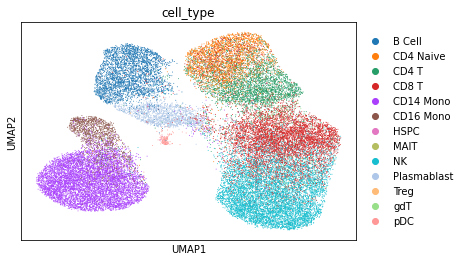

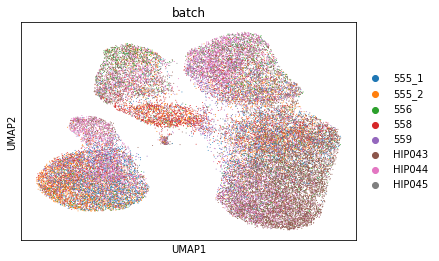

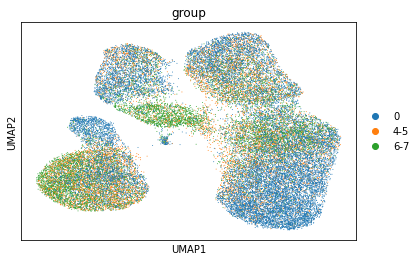

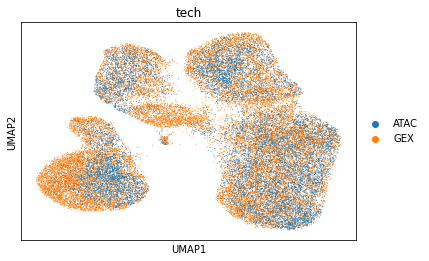

In [9]:
sc.pl.umap(ann_merge, color=["cell_type"], wspace=0.75)
sc.pl.umap(ann_merge, color=["batch"], wspace=0.75)
sc.pl.umap(ann_merge, color=["group"], wspace=0.75)
sc.pl.umap(ann_merge, color=["tech"], wspace=0.75)


In [10]:
merge = ann_merge.obsm['X_umap']
merge = pd.DataFrame(merge)
merge.insert(0, 'index', np.concatenate((input_mod1.obs_names.to_numpy(), 
                                         input_mod2.obs_names.to_numpy()), axis=0))
merge.to_csv('SiaNN_UMAP_BMMCmodel.txt', index=False)

### Label transfer accuracy

In [23]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

def KNN_acc(out_1, out_2, labels_1, labels_2, nn=5):
    neigh = KNeighborsClassifier(n_neighbors=nn, weights='distance')
    neigh.fit(out_1, labels_1)
    ylabel = neigh.predict(out_2)
    acc = np.mean(labels_2 == ylabel)
    print("Accuracy is %s"%(acc))
    return ylabel

In [37]:
labels_x = test_dat.input_mod1.obs['cell_type'].to_numpy() #.cat.codes.to_numpy()
labels_y = test_dat.input_mod2.obs['cell_type'].to_numpy() #.cat.codes.to_numpy()


In [38]:
#for i in range(5,105,5):
#    print(i)
#    pred_y = KNN_acc(out_x, out_y, labels_x, labels_y, nn=i)
#    print()
pred_y = KNN_acc(out_x, out_y, labels_x, labels_y, nn=75)

Accuracy is 0.7636630754162586


In [39]:
#for i in range(5,105,5):
#    print(i)
#    pred_y = KNN_acc(out_y, out_x, labels_y, labels_x, nn=i)
#    print()
pred_x = KNN_acc(out_y, out_x, labels_y, labels_x, nn=75)

Accuracy is 0.7484710743801652


In [40]:
pred_df_x = pd.DataFrame({'cell_type':labels_x,'prediction':pred_x})
pred_df_x.to_csv('SiaNN_prediction.BMMCmodel.atac.txt')

pred_df_y = pd.DataFrame({'cell_type':labels_y,'prediction':pred_y})
pred_df_y.to_csv('SiaNN_prediction.BMMCmodel.rna.txt')

In [41]:
ct_df = pd.DataFrame({'cell_type':labels_y,
                     'prediction':pred_y})
n_ct = len(np.unique(labels_y))
ct_heatmap = pd.DataFrame(np.zeros((n_ct,n_ct)))
ct_heatmap.index = test_dat.input_mod2.obs['cell_type'].unique().tolist()
ct_heatmap.columns = test_dat.input_mod2.obs['cell_type'].unique().tolist()
for i in range(n_ct):
    for j in range(n_ct):
        tmp = ct_df.loc[(ct_df['cell_type'] == ct_heatmap.index[i]),:]
        ct_heatmap.iloc[i,j] = np.mean(tmp['prediction'] == ct_heatmap.columns[j])
        

<AxesSubplot:>

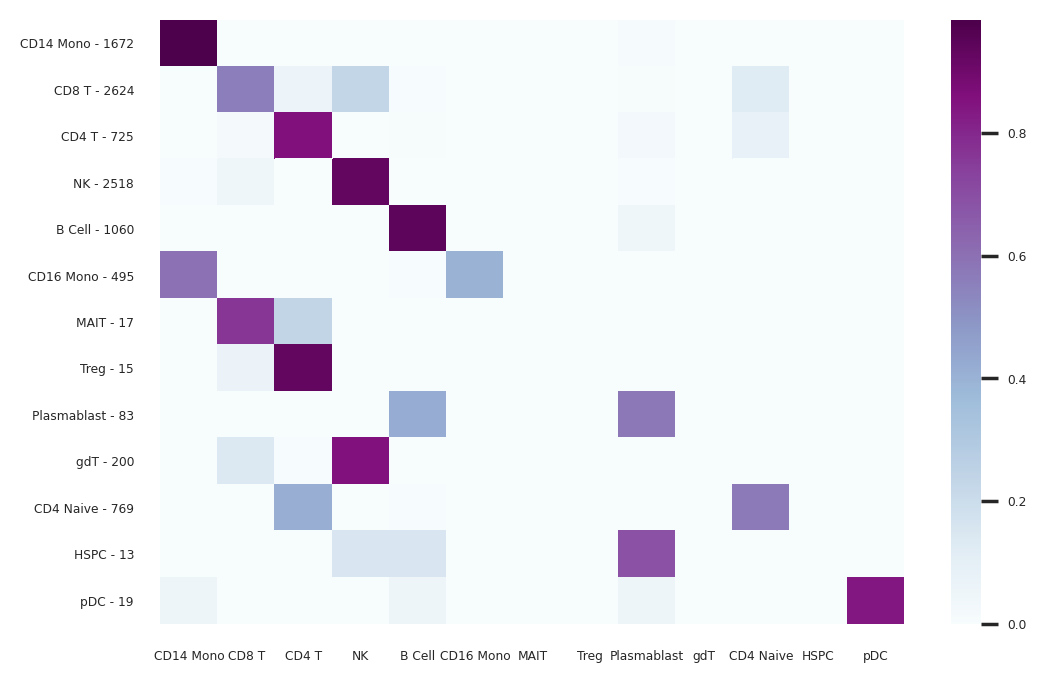

In [42]:
ct_heatmap.index = ct_heatmap.index + ' - ' + ct_df['cell_type'].value_counts().astype(str)[ct_heatmap.index]
sns.set(rc={"figure.dpi":200, 'savefig.dpi':100},font_scale=0.4)
mask = ct_heatmap.isnull()
sns.heatmap(ct_heatmap, mask=mask, cmap="BuPu")

In [43]:
acc_df = pd.DataFrame({'cell_type':ct_heatmap.columns.tolist(),
                       'SiaNN': np.diag(ct_heatmap)})
acc_df.to_csv('SiaNN_transfer_acc.BMMCmodel.atac.csv')

In [44]:
ct_df = pd.DataFrame({'cell_type':labels_x,
                     'prediction':pred_x})
n_ct = len(np.unique(labels_x))
ct_heatmap = pd.DataFrame(np.zeros((n_ct,n_ct)))
ct_heatmap.index = test_dat.input_mod1.obs['cell_type'].unique().tolist()
ct_heatmap.columns = test_dat.input_mod1.obs['cell_type'].unique().tolist()
for i in range(n_ct):
    for j in range(n_ct):
        tmp = ct_df.loc[(ct_df['cell_type'] == ct_heatmap.index[i]),:]
        ct_heatmap.iloc[i,j] = np.mean(tmp['prediction'] == ct_heatmap.columns[j])
        

<AxesSubplot:>

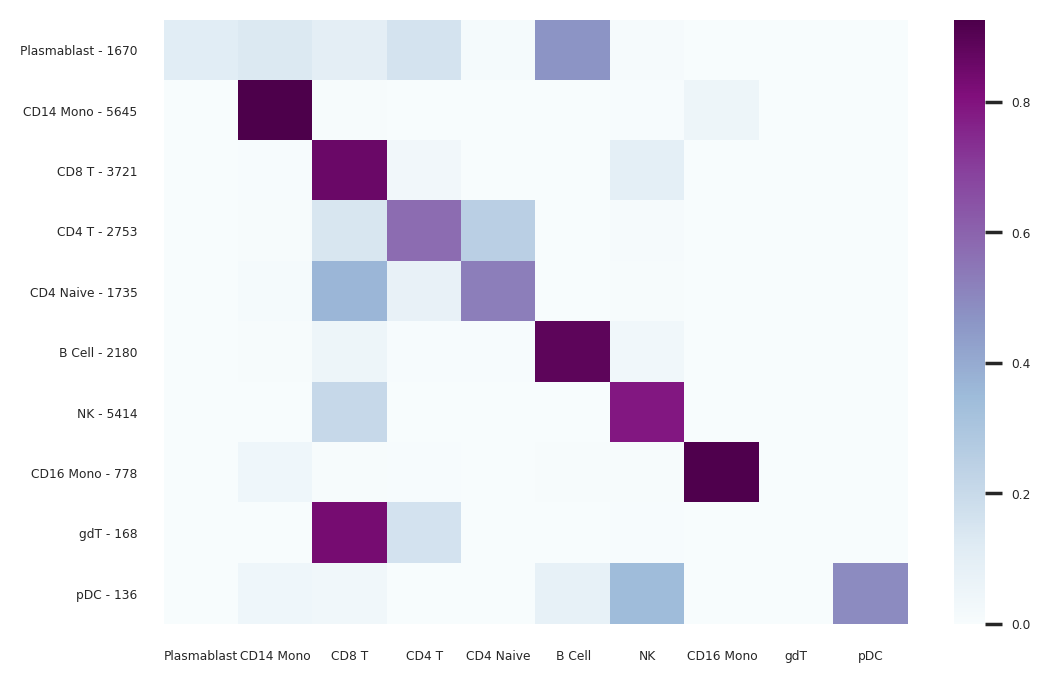

In [45]:
ct_heatmap.index = ct_heatmap.index + ' - ' + ct_df['cell_type'].value_counts().astype(str)[ct_heatmap.index]
sns.set(rc={"figure.dpi":200, 'savefig.dpi':100},font_scale=0.4)
mask = ct_heatmap.isnull()
sns.heatmap(ct_heatmap, mask=mask, cmap="BuPu")

In [46]:
acc_df = pd.DataFrame({'cell_type':ct_heatmap.columns.tolist(),
                       'SiaNN': np.diag(ct_heatmap)})
acc_df.to_csv('SiaNN_transfer_acc.BMMCmodel.rna.csv')